In [ ]:
import numpy as np
from scipy.signal import convolve2d
from skimage.morphology import thin
import matplotlib.pyplot as plt
from skimage.morphology import disk


def plot_scalar_field_with_quiver(Z, Xsub, Ysub, Usub, Vsub):
    img = plt.imshow(
        Z,
        origin="lower",
        extent=(Xsub.min(), Xsub.max(), Ysub.min(), Ysub.max()),
        cmap="viridis",
        aspect="equal",
    )
    plt.colorbar(img, label="Z value")

    plt.quiver(
        Xsub,
        Ysub,
        Usub,
        Vsub,
        angles="xy",
        scale_units="xy",
        scale=20,
        width=0.005,
        headwidth=0,
        headlength=0,
        headaxislength=0,
        pivot="mid",
        color="white",
    )

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Scalar Field with Quiver Overlay")
    plt.tight_layout()
    plt.show()


def make_ring_kernel(radius):

    # large and small disks
    large = disk(radius + 1).astype(int)
    small = disk(radius).astype(int)

    # pad small to same shape as large, centered
    pad_y = large.shape[0] - small.shape[0]
    pad_x = large.shape[1] - small.shape[1]
    pad_top = pad_y // 2
    pad_bottom = pad_y - pad_top
    pad_left = pad_x // 2
    pad_right = pad_x - pad_left

    small_padded = np.pad(
        small,
        ((pad_top, pad_bottom), (pad_left, pad_right)),
        mode="constant",
        constant_values=0,
    )

    # ring kernel is the “shell” between the two disks
    ring_kernel = large - small_padded

    # coordinates centered at zero
    L = ring_kernel.shape[0]
    coords = np.arange(L) - L / 2
    X, Y = np.meshgrid(coords, coords, indexing="xy")

    # compute radius, and mask outside the ring
    r = np.sqrt(X**2 + Y**2)
    X_masked = np.where(ring_kernel, X, 0.0)
    Y_masked = np.where(ring_kernel, Y, 0.0)

    # directional kernels
    deltaX = Y_masked / r
    deltaY = -X_masked / r

    # avoid NaNs at r=0
    deltaX = np.nan_to_num(deltaX)
    deltaY = np.nan_to_num(deltaY)

    return deltaX, deltaY, ring_kernel


import cv2
import numpy as np


def get2DQTensor(nx, ny, QtensorAverageScale, mum_per_px_2D):

    """
    This function computes the 2D Q-tensor from the nematic order parameter and the nematic director.
    The function takes in the "microscopic" director components (nx, ny), the average length scale for the Q-tensor, and the pixel size in micrometers.
    It returns the coarse grained director fields components (nx_cg, ny_cg) and the nematic order parameter (S) as fields.
    """
    
    nx = np.asarray(nx)
    ny = np.asarray(ny)
    Qxx = nx**2 - 1 / 2
    Qxy = nx * ny
    Qxx_cg = cv2.GaussianBlur(Qxx, (0, 0), QtensorAverageScale * mum_per_px_2D ** (-1))
    Qxy_cg = cv2.GaussianBlur(Qxy, (0, 0), QtensorAverageScale * mum_per_px_2D ** (-1))
    S = 2 * np.sqrt(Qxx_cg**2 + Qxy_cg**2)  # nematic order parameter
    Qxx = Qxx_cg / S
    Qxy = Qxy_cg / S
    nx_cg = np.sqrt(Qxx + 1 / 2)
    ny_cg = np.sqrt(1 - nx_cg**2) * np.sign(Qxy)

    return nx_cg, ny_cg, S


def plotQuiver(nx, ny, N=5):
    X, Y = np.meshgrid(
        np.arange(0, nx.shape[0]), np.arange(0, nx.shape[0]), indexing="xy"
    )
    Xsub = X[::N, ::N]
    Ysub = Y[::N, ::N]
    Usub = nx[::N, ::N]
    Vsub = ny[::N, ::N]

    # -- make the quiver plot --
    plt.figure(figsize=(6, 6))
    plt.quiver(
        Xsub,
        Ysub,  # positions
        Usub,
        Vsub,  # vector components
        angles="xy",  # treat U,V as cartesian vectors
        scale_units="xy",  # so scale is in data units
        scale=1,  # no automatic scaling
        width=0.003,  # arrow width
        headwidth=0,  # ← no arrowhead width
        headlength=0,  # ← no arrowhead length
        headaxislength=0,  # ← no arrowhead axis
        pivot="mid",  # center the (invisible) "arrow" on the tail
    )
    plt.axis("equal")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Quiver plot every {N} steps")
    plt.tight_layout()
    plt.show()

Get example defects

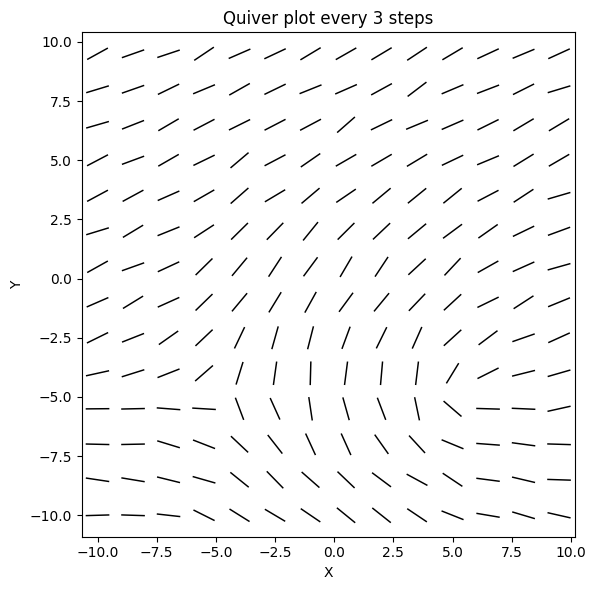

In [3]:
# init ring kernel
radiusLineIntegral = 4
deltaX, deltaY, ring_kernel = make_ring_kernel(radiusLineIntegral)

# parameters
EdgeLength = 10.0
increment = 0.5
y0, x0 = -5.0, 5.0  # defect positions
defectCharge = 0.5

# create the grid
xs = np.arange(-EdgeLength, EdgeLength + increment, increment)
ys = np.arange(-EdgeLength, EdgeLength + increment, increment)
X, Y = np.meshgrid(xs, ys, indexing="xy")


# compute theta field (with a small random “noise”)
theta_angles = (
    defectCharge * np.arctan2(Y - y0, X - x0)
    - defectCharge * np.arctan2(Y - y0, X + x0)
    + 0.05 * np.random.rand(*X.shape) * 2 * np.pi
)

# 3) coarse‐grained orientation
nx = np.cos(theta_angles)
ny = np.sin(theta_angles)


N = 3  # pick a step size
Xsub = X[::N, ::N]
Ysub = Y[::N, ::N]
Usub = nx[::N, ::N]
Vsub = ny[::N, ::N]

# -- make the quiver plot --
plt.figure(figsize=(6, 6))
plt.quiver(
    Xsub,
    Ysub,  # positions
    Usub,
    Vsub,  # vector components
    angles="xy",  # treat U,V as cartesian vectors
    scale_units="xy",  # so scale is in data units
    scale=1,  # no automatic scaling
    width=0.003,  # arrow width
    headwidth=0,  # ← no arrowhead width
    headlength=0,  # ← no arrowhead length
    headaxislength=0,  # ← no arrowhead axis
    pivot="mid",  # center the (invisible) "arrow" on the tail
)
plt.axis("equal")
plt.xlabel("X")
plt.ylabel("Y")
plt.title(f"Quiver plot every {N} steps")
plt.tight_layout()
plt.show()

In [4]:
S, nx_cg, ny_cg = get2DQTensor(
    nx,
    ny,
    QtensorAverageScale=1.0,
    mum_per_px_2D=increment,
)  # this is the function that computes the Q-tensor

In [29]:
import torch as th
import cv2 as cv
import scipy as sp
import numpy as np
from scipy.ndimage import gaussian_filter


def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return rho, phi


def binRadially(R, corr, num_bins=100):
    r_max = np.floor(np.max(R))
    increment = (r_max) / num_bins
    distances = np.arange(0, r_max, increment)
    binned_values = np.zeros(num_bins)
    counter = 0
    for r in distances:
        mask = np.logical_and(R >= r, R < r + increment)
        binned_values[counter] = np.mean(corr[mask])
        counter += 1
    return binned_values, distances


def autocorr2d_radial(native_theta, num_bins=200):
    """returns the radial average of the autocorrelation function"""
    corr = autocorr2d_fft(native_theta)
    [X, Y] = np.meshgrid(
        np.arange(0, corr.shape[1]), np.arange(0, corr.shape[0]), indexing="xy"
    )

    X_centered = X - corr.shape[0] / 2
    Y_centered = Y - corr.shape[1] / 2

    R, theta = cart2pol(X_centered, Y_centered)
    averageCorr, distances = binRadially(R, corr, num_bins)
    return averageCorr, distances


def autocorr2d_fft(img):
    """
    Fast 2D autocorrelation via the Wiener-Khinchin theorem:
    autocorr = IFFT2(|FFT2(img)|^2).
    Returns a map of size 2M*2N (full autocorr), centered at zero lag.
    """
    img = np.asarray(img, dtype=float)
    # subtract mean
    img -= img.mean()
    # pad to avoid circular wrap‐around if you want 'full' result
    M, N = img.shape
    fshape = (2 * M, 2 * N)
    # forward FFT
    F = np.fft.rfft2(img, s=fshape)
    # power spectrum
    P = np.abs(F) ** 2
    # inverse FFT to get autocorrelation
    corr = np.fft.irfft2(P, s=fshape)
    # shift zero‐lag to center
    corr = np.fft.fftshift(corr)

    # normalize
    center = (fshape[0] // 2, fshape[1] // 2)
    return corr / corr[center]


def getGaussianKernel(coarseGrainingLength):
    """
    Returns a Gaussian kernel for coarse graining.
    The kernel is of size (3 * coarseGrainingLength, 3 * coarseGrainingLength)
    """
    helper = np.zeros(
        (
            int(np.round(2.5 * coarseGrainingLength)),
            int(np.round(2.5 * coarseGrainingLength)),
        )
    )
    helper[int(np.floor(helper.shape[0] / 2)), int(np.floor(helper.shape[1] / 2))] = 1
    G = gaussian_filter(
        helper,
        sigma=coarseGrainingLength,
    )
    G = th.from_numpy(G)
    G = G.unsqueeze(0).unsqueeze(0)
    G = G.float()
    return G


def smart_structure_tensor(
    img_tensor,
    coarseGrainAverage="gaussian",
    coarseGrainingLength=4,
    downsample=2,
    method="inter_area",
):
    nativeDimensions = img_tensor.shape[2:]

    if coarseGrainAverage == "gaussian":
        # get gaussian kernel
        G = getGaussianKernel(coarseGrainingLength)
    elif coarseGrainAverage == "mean":
        # get avergae kernel
        G = np.ones((coarseGrainingLength, coarseGrainingLength)) / (
            coarseGrainingLength**2
        )
        G = th.from_numpy(G)
        G = G.unsqueeze(0).unsqueeze(0)
        G = G.float()

    G_small = getGaussianKernel(1)
    img_tensor = th.conv2d(img_tensor, G_small, padding="same")
    # get gradients
    sobel_x = (
        th.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=th.float32)
        .unsqueeze(0)
        .unsqueeze(0)
    )
    sobel_y = (
        th.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=th.float32)
        .unsqueeze(0)
        .unsqueeze(0)
    )
    Ix = th.conv2d(img_tensor, sobel_x, padding="same")
    Iy = th.conv2d(img_tensor, sobel_y, padding="same")

    # construct structure tensor
    Ixx = th.conv2d(Ix * Ix, G, stride=downsample)
    Iyy = th.conv2d(Iy * Iy, G, stride=downsample)
    Ixy = th.conv2d(Ix * Iy, G, stride=downsample)

    tr = Ixx + Iyy
    diff = Ixx - Iyy
    enum = th.sqrt(diff**2 + 4 * Ixy**2)

    # smallest eigenvalue
    lambda2 = tr / 2 - th.sqrt(enum) / 2
    # corresponding eigenvector
    eigenvector2 = th.zeros(Ixx.shape[2], Ixx.shape[3], 2)
    eigenvector2[:, :, 0] = Ixy
    eigenvector2[:, :, 1] = lambda2 - Ixx
    # normalize eigenvectors
    norm = th.sqrt(eigenvector2[:, :, 0] ** 2 + eigenvector2[:, :, 1] ** 2)
    eigenvector2[:, :, 0] = eigenvector2[:, :, 0] / norm
    eigenvector2[:, :, 1] = eigenvector2[:, :, 1] / norm

    nx = eigenvector2[:, :, 0]
    ny = eigenvector2[:, :, 1]

    theta = th.acos(np.abs(nx))
    # theta = th.atan2(ny, nx)
    if method == "inter_area":
        theta_reconstruct = cv.resize(
            theta.numpy(),
            (nativeDimensions[1], nativeDimensions[0]),
            interpolation=cv.INTER_AREA,
        )
    elif method == "inter_nearest":
        theta_reconstruct = cv.resize(
            theta.numpy(),
            (nativeDimensions[1], nativeDimensions[0]),
            interpolation=cv.INTER_NEAREST_EXACT,
        )
    elif method == "inter_cubic":
        theta_reconstruct = cv.resize(
            theta.numpy(),
            (nativeDimensions[1], nativeDimensions[0]),
            interpolation=cv.INTER_CUBIC,
        )
    elif method == "inter_lanczos4":
        theta_reconstruct = cv.resize(
            theta.numpy(),
            (nativeDimensions[1], nativeDimensions[0]),
            interpolation=cv.INTER_LANCZOS4,
        )
    return theta_reconstruct

C:\Users\Pablo\AppData\Local\Temp\ipykernel_78664\3677993314.py:150: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  theta = th.acos(np.abs(nx))


Time native:  1.943538300009095
Time reconstructed:  0.7960142999945674


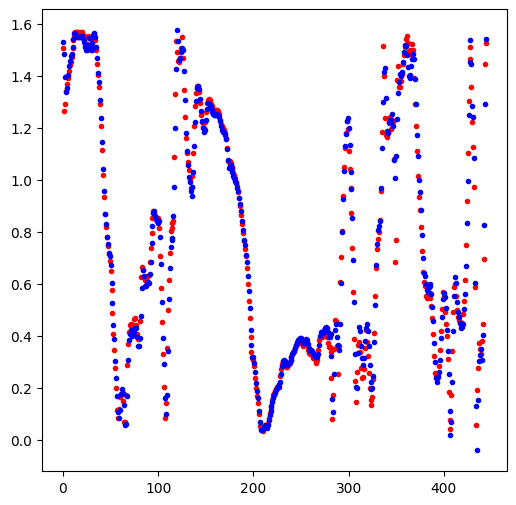

In [73]:
import torch as th
import tifffile as tiff
from matplotlib import pyplot as plt
import cv2 as cv
import timeit


testName = "E:/Taubenberger CAF/CAF HE analysis/CAF HE analysis/example SVS/Tiles/558999/patient_UpperLeft(10500,18000)small.tiff"
img = cv2.imread(testName)
img = np.mean(img, axis=2)
img_tensor = th.from_numpy(img)
# batch size, channels, height, width
img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)
img_tensor = img_tensor.float()

coarseGrainingLength_px = 20
downsample_reconstruction = 2

time_native = timeit.timeit(
    lambda: smart_structure_tensor(
        img_tensor, coarseGrainingLength=coarseGrainingLength_px, downsample=1
    ),
    number=100,
)
native_theta = smart_structure_tensor(
    img_tensor, coarseGrainingLength=coarseGrainingLength_px, downsample=1
)


time_reconstructed = timeit.timeit(
    lambda: smart_structure_tensor(
        img_tensor,
        coarseGrainingLength=coarseGrainingLength_px,
        downsample=downsample_reconstruction,
        method="inter_cubic",
    ),
    number=100,
)
reconstructed_theta = smart_structure_tensor(
    img_tensor,
    coarseGrainingLength=coarseGrainingLength_px,
    downsample=downsample_reconstruction,
    method="inter_cubic",
)

print("Time native: ", time_native)
print("Time reconstructed: ", time_reconstructed)
plt.figure(figsize=(6, 6))
plt.plot(native_theta[:, 10], "r.")
plt.plot(reconstructed_theta[:, 10], "b.")

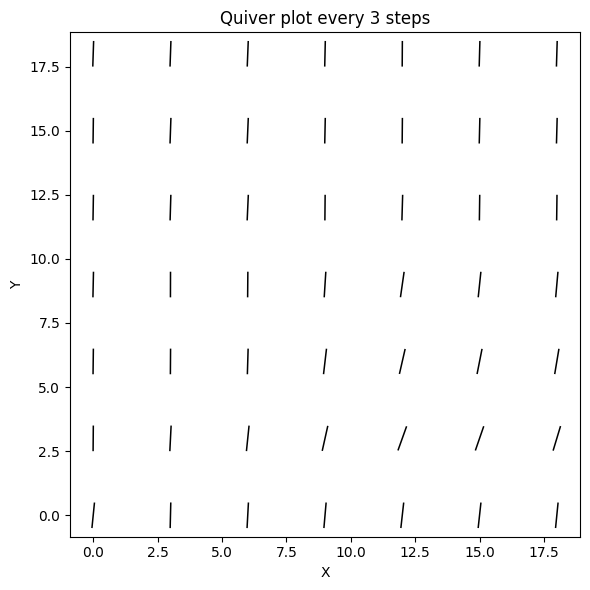

In [79]:
plotQuiver(
    np.cos(reconstructed_theta[1:20, 1:20]),
    np.sin(reconstructed_theta[1:20, 1:20]),
    N=3,
)

plotting stuff

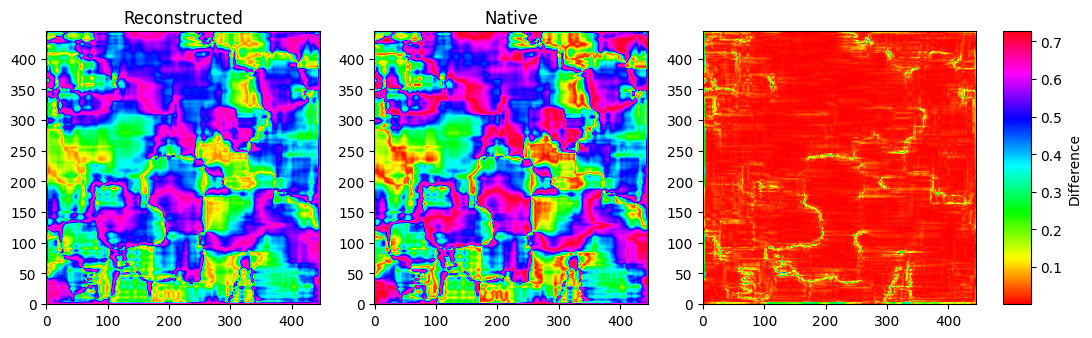

In [74]:
def add_colorbar(im, width=None, pad=None, **kwargs):

    l, b, w, h = im.axes.get_position().bounds  # get boundaries
    width = width or 0.1 * w  # get width of the colorbar
    pad = pad or width  # get pad between im and cbar
    fig = im.axes.figure  # get figure of image
    cax = fig.add_axes([l + w + pad, b, width, h])  # define cbar Axes
    return fig.colorbar(im, cax=cax, **kwargs)  # draw cbar


fig, axes = plt.subplots(1, 3, figsize=(12, 24))


reconstructed = axes[0].imshow(reconstructed_theta, cmap="hsv", origin="lower")


axes[0].set_title("Reconstructed")


axes[1].imshow(native_theta, cmap="hsv", origin="lower")

axes[1].set_title("Native")

diff_im = axes[2].imshow(
    np.abs(native_theta - reconstructed_theta) / (np.pi / 2), cmap="hsv", origin="lower"
)

add_colorbar(diff_im, label="Difference")

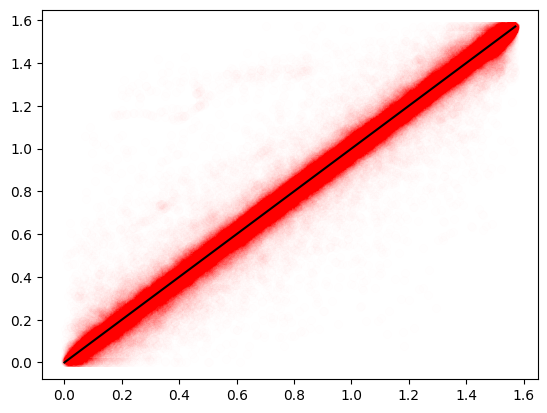

In [71]:
reconstructed_theta[np.where(reconstructed_theta < 0)] = 0
reconstructed_theta[np.where(reconstructed_theta > (np.pi / 2))] = np.pi / 2

plt.scatter(
    native_theta[10:],
    reconstructed_theta[10:],
    c="r",
    label="First 10 points",
    alpha=0.005,
)

plt.plot([0, np.pi / 2], [0, np.pi / 2], c="k", label="y=x line")
pearson_correlation = np.corrcoef(
    native_theta[10:].flatten(), reconstructed_theta[10:].flatten()
)

In [63]:
print(np.max(reconstructed_theta))
print(np.max(native_theta))

print(pearson_correlation)

1.7377137
1.5704584
[[1.         0.98660584]
 [0.98660584 1.        ]]


C:\Users\Pablo\AppData\Local\Temp\ipykernel_78664\3677993314.py:150: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  theta = th.acos(np.abs(nx))


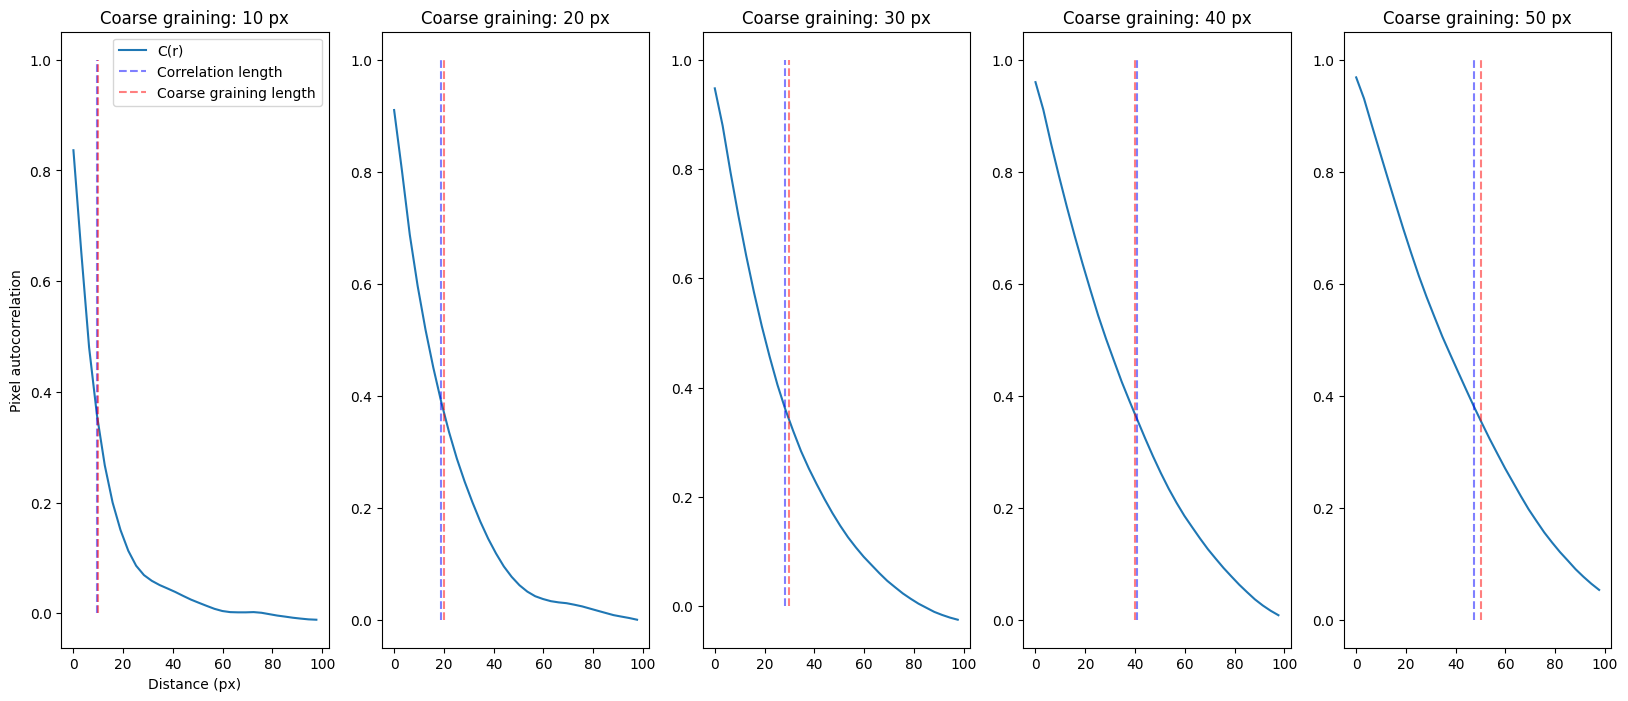

In [45]:
# plot the correlation length versus the coarse graining length
fig, axes = plt.subplots(1, 5, figsize=(20, 8))

for i in range(5):
    coarseGrainingLength_px = (i + 1) * 10
    native_theta = smart_structure_tensor(
        img_tensor, coarseGrainingLength=coarseGrainingLength_px, downsample=1
    )
    averageCorr, distances = autocorr2d_radial(native_theta, num_bins=200)
    axes[i].plot(
        distances[distances < 100],
        averageCorr[distances < 100],
        label="native",
    )
    minInd = np.argmin(np.abs(averageCorr - np.exp(-1)))
    axes[i].vlines(distances[minInd], 0, 1, color="blue", linestyle="--", alpha=0.5)
    axes[i].vlines(
        coarseGrainingLength_px, 0, 1, color="red", linestyle="--", alpha=0.5
    )
    axes[i].set_title(f"Coarse graining: {coarseGrainingLength_px} px")
axes[0].set_ylabel("Pixel autocorrelation")
axes[0].set_xlabel("Distance (px)")
axes[0].legend(["C(r)", "Correlation length", "Coarse graining length"])

plot coarse graining length vs correlation length

In [30]:
# plot the correlation length versus the coarse graining length
coarseGrainingLength_input = np.zeros(100)
correlationLength_output = np.zeros(100)
for i in range(50):
    coarseGrainingLength_px = i + 1
    native_theta = smart_structure_tensor(
        img_tensor,
        coarseGrainAverage="gaussian",
        coarseGrainingLength=coarseGrainingLength_px,
        downsample=1,
    )
    averageCorr, distances = autocorr2d_radial(native_theta, num_bins=200)
    # calc correlation length
    minInd = np.argmin(np.abs(averageCorr - np.exp(-1)))

    correlationLength_output[i] = distances[minInd]
    coarseGrainingLength_input[i] = coarseGrainingLength_px

C:\Users\Pablo\AppData\Local\Temp\ipykernel_78664\3677993314.py:112: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  img_tensor = th.conv2d(img_tensor, G_small, padding="same")
C:\Users\Pablo\AppData\Local\Temp\ipykernel_78664\3677993314.py:150: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  theta = th.acos(np.abs(nx))


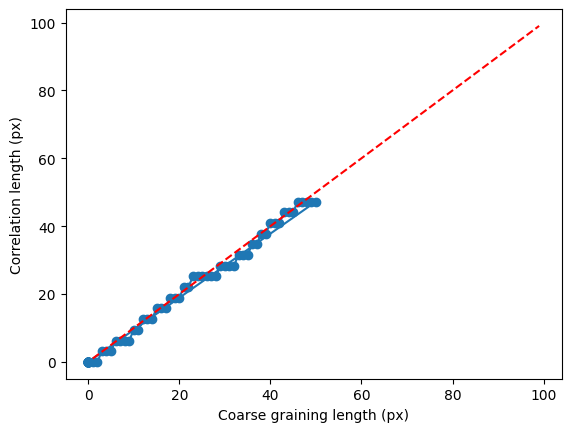

In [31]:
plt.plot(
    coarseGrainingLength_input,
    correlationLength_output,
    "o-",
)
plt.xlabel("Coarse graining length (px)")
plt.ylabel("Correlation length (px)")
plt.plot(np.arange(1, 100), np.arange(1, 100), "r--", label="y=x")